<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/customnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Neural Net

In [2]:
from numpy import loadtxt
import numpy as np
import os
import shutil
import math
import zipfile
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Optimizer
from keras import backend as K

import sklearn 
from sklearn import metrics
import tensorflow_addons as tfa

# GPU Setup

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Unzip Dataset

In [15]:
dataset_name = 'dataset_binary'
zip_file_path = '/content/' + dataset_name + '.zip'
unzipped_dir = '/content'
dataset_X = '/content/' + dataset_name
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzipped_dir)

#Create Dataloader

In [16]:
BATCH_SIZE = 32
ORIG_IMG_SIZE = (96, 96)
ORIG_COLOR_MODE ='grayscale'
IMG_SIZE = (96, 96)
COLOR_MODE = 'grayscale'
LABEL_MODE='categorical'

train_dataset = image_dataset_from_directory(dataset_X +'/train/', label_mode=LABEL_MODE, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
dev_dataset = image_dataset_from_directory(dataset_X +'/dev/', label_mode=LABEL_MODE, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
test_dataset = image_dataset_from_directory(dataset_X +'/test/', label_mode=LABEL_MODE, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)

Found 33915 files belonging to 2 classes.
Found 5339 files belonging to 2 classes.
Found 2819 files belonging to 2 classes.


In [17]:
def show_example(train_dataset):
  for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = np.asarray(image[0]).squeeze()
    print(first_image.shape)
    # for i in range(9):
    #   ax = plt.subplot(3, 3, i + 1)
      # augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
      # plt.imshow(augmented_image[0] / 255)
    # print(image)
    plt.gray()
    plt.imshow(first_image / 255, plt.get_cmap('gray'))
    plt.axis('off')
    
    break 

# Run with this line:
# show_example(train_dataset)

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
dev_dataset = dev_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Fully Connected Model

In [19]:
num_classes = 2

# last_layer = Dense(2, activation='softmax', name='15', kernel_initializer="glorot_uniform") if num_classes == 2 else Dense(3, activation='softmax')

In [22]:

# model_cnn = keras.Sequential(
#     [
#         keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1], 1)),  # 96x96 greyscale image
#         layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation="relu"),
#         layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation="relu"),
#         layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation="relu"),
#         layers.MaxPool2D(),
#         layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation="relu"),        # layers.MaxPool2D(),
#         layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation="relu"),
#         layers.MaxPool2D(),
#         layers.Flatten(name='flatten'),
#         Dense(100, activation='relu'),
#         Dense(100, activation='relu'),
#         Dense(64, activation='relu'),
#         last_layer  
#     ]
# )

In [152]:
# initializer = "glorot_uniform" #tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
model_full = keras.Sequential(
    [
        keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1], 1)),  # 96x96 greyscale image
        layers.Flatten(name='flatten'),
        Dense(64, activation='relu', name='1'), #, kernel_initializer=initializer),
        Dense(64, activation='relu', name='2'), #, kernel_initializer=initializer),
        Dense(64, activation='relu', name='3'), #, kernel_initializer=initializer),
        Dense(64, activation='relu', name='4'), #, kernel_initializer=initializer),
        Dense(128, activation='relu', name='5'), #, kernel_initializer=initializer),
        Dense(128, activation='relu', name='6'), #, kernel_initializer=initializer),
        Dense(128, activation='relu', name='7'), #, kernel_initializer=initializer),
        Dense(128, activation='relu', name='8'), #, kernel_initializer=initializer),
        Dense(128, activation='relu', name='9'), #, kernel_initializer=initializer),
        Dense(64, activation='relu', name='10'), #, kernel_initializer=initializer),
        Dense(64, activation='relu', name='11'), #, kernel_initializer=initializer),
        Dense(64, activation='relu', name='12'), #, kernel_initializer=initializer),
        Dense(64, activation='relu', name='13'), #, kernel_initializer=initializer),
        Dense(64, activation='relu', name='14'), #, kernel_initializer=initializer),
        Dense(2, activation='softmax', name='15'), #, kernel_initializer=initializer)
        # Dense(1, activation='sigmoid', name='15', kernel_initializer=initializer)
    ]
)

In [153]:
model = model_full
# model.summary()

In [154]:
def f1_score(num_classes):
  return tfa.metrics.F1Score(num_classes=num_classes, average="weighted")

# Standard Optimizer

In [155]:
# Compile model with accuracy and weighted F1 Score
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score(num_classes)])

# Custom Optimizer
Implements model with power of two weights.

In [156]:
# def closestpow2numpy(num):
#   return np.sign(num)*np.array(np.power(2, np.round(np.log(np.round(np.absolute(num)))/np.log(2))), dtype=int)

# print(closestpow2numpy([0, 1, 2, 3, 4, 6.1, 32, 1.29, 1.5, 0.001]))
# print(closestpow2numpy(-1*np.array([0, 1, 2, 3, 4, 6.1, 32, 1.29, 1.5, 0.001])))


# def intsnumpy(num):
#   return np.round_(np.clip(16*(num - np.mean(num)) / np.sqrt(np.var(num)), -16.,16))

# print(intsnumpy([0, 1, 2, 3, 4, 6.1, 32, 1.29, 1.5, 0.001]))
# print(intsnumpy(-1*np.array([0, 1, 2, 3, 4, 6.1, 32, 1.29, 1.5, 0.001])))

def closestpow2fixedptnumpy(num):
  return np.sign(num)*np.array(np.power(2, np.round(np.log(np.absolute(num))/np.log(2))), dtype=float)

print(closestpow2fixedptnumpy(np.array([0.0012, 0.23, 0.53, 0.38, 0.75, 0.127])))
print(closestpow2fixedptnumpy(-1*np.array([0.0012, 0.23, 0.53, 0.38, 0.75, 0.127])))


[9.765625e-04 2.500000e-01 5.000000e-01 5.000000e-01 1.000000e+00
 1.250000e-01]
[-9.765625e-04 -2.500000e-01 -5.000000e-01 -5.000000e-01 -1.000000e+00
 -1.250000e-01]


In [157]:
# def closestpow2(num):
#   return K.cast(K.sign(num)*K.pow(2, K.round(K.log(K.abs(num))/K.log(2))), dtype='float32')
def closestpow2(num):
  return K.cast(K.sign(num)*K.pow(2.0, K.round(K.log(K.abs(num))/K.log(2.0))), dtype='float32')

# def ints(num):
#   return K.round(K.clip(16*(num - K.mean(num)) / K.sqrt(K.var(num)), -16.,16))



In [158]:
class Pow2Update(Optimizer):
  def __init__(self, learning_rate=0.001, name="Pow2Update", **kwargs):
    super(Pow2Update, self).__init__(name, **kwargs)
    # self.lr = lr
    self._set_hyper("learning_rate", kwargs.get("lr", learning_rate))

  # def _create_slots(self, var_list):
    # for var in var_list:

  # def closestpow2(num):
  #   return K.cast(K.sign(num)*K.pow(2.0, K.round(K.log(K.abs(num))/K.log(2.0))), dtype='float32')

  @tf.function
  def _resource_apply_dense(self, grad, var):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    lr_t = self._decayed_lr(var_dtype)
    # lr_t, kwargs = self._get_lr(var.device, var.dtype.base_dtype, apply_state

    # var.assign(var - lr_t*grad)
    var.assign(closestpow2(var - lr_t*grad))
    # var.assign(closestpow2(var - closestpow2(lr_t*grad)))
    # var.assign(K.clip(var - lr_t*grad, -16, 16))
    
    # mean = K.mean(var)
    # stddev = K.sqrt(K.var(var))
    # shifted_var = (var - mean) / stddev
    # var.assign(K.round(K.clip(shifted_var, -16.,16)))
    
    # return K.cast(K.sign(grad)*K.pow(2.0, K.round(K.log(K.abs(grad))/K.log(2.0))), dtype='float32')
  
  def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

  def get_config(self):
      base_config = super().get_config()
      return {
          **base_config,
          "learning_rate": self._serialize_hyperparameter("learning_rate"),
          # "pow2": closestpow2(-0.51),
      }


In [159]:
po = Pow2Update()

po.get_config()

{'learning_rate': 0.001, 'name': 'Pow2Update'}

In [160]:
K.clear_session()
model.get_weights()

[array([[-0.01445325, -0.00731609, -0.00055201, ...,  0.00496222,
         -0.01656716,  0.02048134],
        [ 0.01268787,  0.00143631,  0.00374478, ...,  0.01151188,
         -0.00303318, -0.00163359],
        [ 0.00757879, -0.02031858, -0.02117635, ..., -0.01967565,
         -0.01079816, -0.00061337],
        ...,
        [ 0.01953373, -0.01447495,  0.02175396, ..., -0.00531799,
          0.02042342,  0.00152987],
        [-0.01123894, -0.0141051 ,  0.00757018, ...,  0.00177073,
          0.01161261, -0.00270278],
        [-0.02378686,  0.01414044,  0.0157065 , ...,  0.02522392,
          0.01269331,  0.02362107]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([[ 0.01587273, -0.11919029,  0.08053617, ..., 

In [162]:
model.compile(loss='categorical_crossentropy', optimizer=Pow2Update(learning_rate=0.005), metrics=['accuracy', f1_score(num_classes)])
# model.compile(loss='categorical_crossentropy', optimizer=Pow2Update(learning_rate=0.005), metrics=['accuracy'])

# Initial Model Training

## Initial results without training

In [163]:
# loss0, accuracy0 = model.evaluate(dev_dataset)
loss0, accuracy0, f1_score0 = model.evaluate(dev_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial f1_score: {:.2f}".format(f1_score0))

167/167 [==============================] - 2s 14ms/step - loss: 1.1263 - accuracy: 0.4999 - f1_score: 0.3332
initial loss: 1.13
initial accuracy: 0.50
initial f1_score: 0.33


## Fit (Initial)

In [164]:
initial_epochs = 30

In [165]:
# Configure eary stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [166]:
history = model.fit(train_dataset,
                epochs=initial_epochs,
                validation_data=dev_dataset)
# ,
                # callbacks=[callback])
  # model.fit(train_it, epochs=20, batch_size=batchX.shape[0], validation_data=dev_it, validation_batch_size=batchX.shape[0])

Epoch 1/30
1060/1060 [==============================] - 18s 17ms/step - loss: 0.6187 - accuracy: 0.6786 - f1_score: 0.6657 - val_loss: 0.6285 - val_accuracy: 0.6477 - val_f1_score: 0.6380
Epoch 2/30
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5933 - accuracy: 0.7033 - f1_score: 0.6915 - val_loss: 0.6143 - val_accuracy: 0.6619 - val_f1_score: 0.6540
Epoch 3/30
1060/1060 [==============================] - 19s 18ms/step - loss: 0.5863 - accuracy: 0.7108 - f1_score: 0.6993 - val_loss: 0.6105 - val_accuracy: 0.6674 - val_f1_score: 0.6592
Epoch 4/30
1060/1060 [==============================] - 19s 17ms/step - loss: 0.5826 - accuracy: 0.7119 - f1_score: 0.7005 - val_loss: 0.6062 - val_accuracy: 0.6692 - val_f1_score: 0.6624
Epoch 5/30
1060/1060 [==============================] - 19s 18ms/step - loss: 0.5799 - accuracy: 0.7161 - f1_score: 0.7050 - val_loss: 0.6098 - val_accuracy: 0.6674 - val_f1_score: 0.6573
Epoch 6/30
1060/1060 [==============================] - 19s 

In [172]:
binary = True
if binary:
  model.save('/content/binary_model_1')

save_to_drive=True
if save_to_drive:
  model.save('/content/drive/My Drive/Haptic Vest/binary_model_1')

INFO:tensorflow:Assets written to: /content/binary_model_1/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Haptic Vest/binary_model_1/assets


In [173]:
second_train_epochs=30

In [174]:
history_cont = model.fit(train_dataset,
                initial_epoch=history.epoch[-1],
                epochs=second_train_epochs,
                validation_data=dev_dataset)

Epoch 1/30
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5414 - accuracy: 0.7407 - f1_score: 0.7334 - val_loss: 0.5763 - val_accuracy: 0.6998 - val_f1_score: 0.6946
Epoch 2/30
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5412 - accuracy: 0.7404 - f1_score: 0.7323 - val_loss: 0.5843 - val_accuracy: 0.6947 - val_f1_score: 0.6867
Epoch 3/30
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5415 - accuracy: 0.7419 - f1_score: 0.7344 - val_loss: 0.5836 - val_accuracy: 0.6917 - val_f1_score: 0.6841
Epoch 4/30
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5409 - accuracy: 0.7418 - f1_score: 0.7340 - val_loss: 0.5790 - val_accuracy: 0.6945 - val_f1_score: 0.6884
Epoch 5/30
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5404 - accuracy: 0.7424 - f1_score: 0.7345 - val_loss: 0.5767 - val_accuracy: 0.6983 - val_f1_score: 0.6927
Epoch 6/30
1060/1060 [==============================] - 18s 

In [175]:
binary = True
if binary:
  model.save('/content/binary_model_2')

save_to_drive=True
if save_to_drive:
  model.save('/content/drive/My Drive/Haptic Vest/binary_model_2')

INFO:tensorflow:Assets written to: /content/binary_model_2/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Haptic Vest/binary_model_2/assets


In [177]:
third_train_epochs=30 + second_train_epochs

history_cont2 = model.fit(train_dataset,
                initial_epoch=history.epoch[-1],
                epochs=third_train_epochs,
                validation_data=dev_dataset)

Epoch 30/60
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5275 - accuracy: 0.7515 - f1_score: 0.7440 - val_loss: 0.5668 - val_accuracy: 0.7084 - val_f1_score: 0.7034
Epoch 31/60
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5287 - accuracy: 0.7503 - f1_score: 0.7442 - val_loss: 0.5703 - val_accuracy: 0.7050 - val_f1_score: 0.6988
Epoch 32/60
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5274 - accuracy: 0.7502 - f1_score: 0.7437 - val_loss: 0.5683 - val_accuracy: 0.7059 - val_f1_score: 0.7005
Epoch 33/60
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5273 - accuracy: 0.7509 - f1_score: 0.7446 - val_loss: 0.5692 - val_accuracy: 0.7065 - val_f1_score: 0.7004
Epoch 34/60
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5266 - accuracy: 0.7510 - f1_score: 0.7451 - val_loss: 0.5691 - val_accuracy: 0.7050 - val_f1_score: 0.6992
Epoch 35/60
1060/1060 [==============================] 

In [178]:
binary = True
if binary:
  model.save('/content/binary_model_3')

save_to_drive=True
if save_to_drive:
  model.save('/content/drive/My Drive/Haptic Vest/binary_model_3')

INFO:tensorflow:Assets written to: /content/binary_model_3/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Haptic Vest/binary_model_3/assets


In [179]:
fourth_train_epochs=30 + third_train_epochs

history_cont3 = model.fit(train_dataset,
                initial_epoch=history_cont2.epoch[-1],
                epochs=fourth_train_epochs,
                validation_data=dev_dataset)

Epoch 60/90
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5182 - accuracy: 0.7574 - f1_score: 0.7513 - val_loss: 0.5629 - val_accuracy: 0.7166 - val_f1_score: 0.7109
Epoch 61/90
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5187 - accuracy: 0.7569 - f1_score: 0.7502 - val_loss: 0.5577 - val_accuracy: 0.7157 - val_f1_score: 0.7115
Epoch 62/90
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5177 - accuracy: 0.7571 - f1_score: 0.7510 - val_loss: 0.5717 - val_accuracy: 0.7084 - val_f1_score: 0.7004
Epoch 63/90
1060/1060 [==============================] - 19s 17ms/step - loss: 0.5175 - accuracy: 0.7569 - f1_score: 0.7508 - val_loss: 0.5630 - val_accuracy: 0.7140 - val_f1_score: 0.7087
Epoch 64/90
1060/1060 [==============================] - 18s 17ms/step - loss: 0.5175 - accuracy: 0.7572 - f1_score: 0.7516 - val_loss: 0.5617 - val_accuracy: 0.7153 - val_f1_score: 0.7106
Epoch 65/90
1060/1060 [==============================] 

In [180]:
binary = True
if binary:
  model.save('/content/binary_model_4')

save_to_drive=True
if save_to_drive:
  model.save('/content/drive/My Drive/Haptic Vest/binary_model_4')

INFO:tensorflow:Assets written to: /content/binary_model_4/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Haptic Vest/binary_model_4/assets


In [ ]:
fifth_train_epochs=300 + fourth_train_epochs

history_cont4 = model.fit(train_dataset,
                initial_epoch=history_cont3.epoch[-1],
                epochs=fifth_train_epochs,
                validation_data=dev_dataset)

Epoch 90/390
1060/1060 [==============================] - 17s 16ms/step - loss: 0.5121 - accuracy: 0.7617 - f1_score: 0.7558 - val_loss: 0.5653 - val_accuracy: 0.7117 - val_f1_score: 0.7041
Epoch 91/390
1060/1060 [==============================] - 17s 16ms/step - loss: 0.5124 - accuracy: 0.7607 - f1_score: 0.7542 - val_loss: 0.5613 - val_accuracy: 0.7116 - val_f1_score: 0.7049
Epoch 92/390
1060/1060 [==============================] - 17s 16ms/step - loss: 0.5118 - accuracy: 0.7631 - f1_score: 0.7559 - val_loss: 0.5548 - val_accuracy: 0.7164 - val_f1_score: 0.7112
Epoch 93/390
1060/1060 [==============================] - 17s 16ms/step - loss: 0.5118 - accuracy: 0.7623 - f1_score: 0.7559 - val_loss: 0.5623 - val_accuracy: 0.7106 - val_f1_score: 0.7037
Epoch 94/390
1060/1060 [==============================] - 17s 16ms/step - loss: 0.5108 - accuracy: 0.7635 - f1_score: 0.7570 - val_loss: 0.5620 - val_accuracy: 0.7140 - val_f1_score: 0.7072
Epoch 95/390
1060/1060 [==========================

In [ ]:
binary = True
if binary:
  model.save('/content/binary_model_5')

save_to_drive=True
if save_to_drive:
  model.save('/content/drive/My Drive/Haptic Vest/binary_model_5')

## Learning Plot

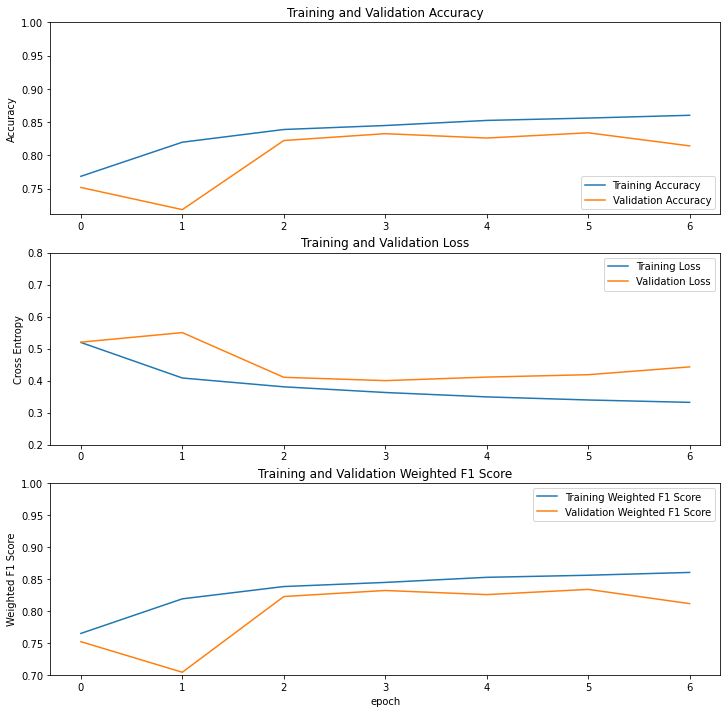

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


f1_score_hist = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.2,0.8])
plt.title('Training and Validation Loss')

plt.subplot(3, 1, 3)
plt.plot(f1_score_hist, label='Training Weighted F1 Score')
plt.plot(val_f1_score, label='Validation Weighted F1 Score')
plt.legend(loc='upper right')
plt.ylabel('Weighted F1 Score')
plt.ylim([0.7,1.0])
plt.title('Training and Validation Weighted F1 Score')
plt.xlabel('epoch')
plt.show()

# Rounded Weights Evaluation

In [614]:
def modify_weights(weights, transform):
  new_weights = []
  for layer_num, layer_weights in enumerate(weights):
    if layer_num < len(weights):
      new_weights.append(transform(layer_weights))
      # print(f"=============== Layer {layer_num} ===============\n")
      # print(layer_weights)
      # print(new_weights[layer_num])
      # print('\n')
  return new_weights


def round2(layer_weights):
  return np.round_(layer_weights, 2)

def round1(layer_weights):
  return np.round_(layer_weights, 1)

def round0(layer_weights):
  return np.round_(layer_weights)

def pow_2_scale(layer_weights):
  sign = binarise(layer_weights)
  pow_2 = sign*2**(-np.round_(np.log2(np.absolute(layer_weights))))
  return pow_2

def binarise(layer_weights):
  return 2*((layer_weights < 0) - 0.5)

def ints_scaling(layer_weights):
  return np.round_(np.clip(100*(layer_weights - np.mean(layer_weights)) / np.sqrt(np.var(layer_weights)), -100.,100))

# transform = round2
# transform = pow_2_scale
# transform = binarise
transform = ints_scaling


weights = model.get_weights() # returs a numpy list of weights
new_weights = modify_weights(weights, transform)
# print(new_weights[0].shape)
print(new_weights[0][:,0])
# print(new_weights[15][1])
# print(weights[28].shape)

[ -35.  -28. -100. ... -100. -100.  -33.]


In [615]:
# fileptr = open('weights_test.txt','ab')
# for layer_weights in new_weights:
#     np.savetxt(fileptr, layer_weights, delimiter=' ')
# fileptr.close()

In [168]:


binarised_test_model = keras.models.load_model('/content/binary_model_1', custom_objects={'Pow2Update':Pow2Update(), 'F1Score': tfa.metrics.F1Score})

In [617]:
binarised_test_model.set_weights(new_weights)

In [171]:
_, accuracy = binarised_test_model.evaluate(train_dataset)
print('Accuracy: %.2f' % (accuracy*100))

_, accuracy, f1_score = model.evaluate(train_dataset)
print('Accuracy: %.2f' % (accuracy*100))

_, accuracy = binarised_test_model.evaluate(dev_dataset)
print('Accuracy: %.2f' % (accuracy*100))

_, accuracy, f1_score = model.evaluate(dev_dataset)
print('Accuracy: %.2f' % (accuracy*100))

_, accuracy = binarised_test_model.evaluate(test_dataset)
print('Accuracy: %.2f' % (accuracy*100))

_, accuracy, f1_score = model.evaluate(test_dataset)
print('Accuracy: %.2f' % (accuracy*100))


1060/1060 [==============================] - 14s 14ms/step - loss: 0.5454 - accuracy: 0.7349
Accuracy: 73.49
1060/1060 [==============================] - 15s 14ms/step - loss: 0.5406 - accuracy: 0.7415 - f1_score: 0.7353
Accuracy: 74.15
167/167 [==============================] - 2s 13ms/step - loss: 0.5980 - accuracy: 0.6932
Accuracy: 69.32
167/167 [==============================] - 2s 13ms/step - loss: 0.5820 - accuracy: 0.6956 - f1_score: 0.6884
Accuracy: 69.56
89/89 [==============================] - 1s 12ms/step - loss: 0.5995 - accuracy: 0.6939
Accuracy: 69.39
89/89 [==============================] - 1s 14ms/step - loss: 0.5726 - accuracy: 0.7063 - f1_score: 0.7004
Accuracy: 70.63


# Evaluate on Test Set
(COMMENTED until development finished)

In [ ]:
# _, accuracy = model.evaluate(dev_it)
# print('Accuracy: %.2f' % (accuracy*100))

# Convert tf model to tflite

In [ ]:
# Convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)